In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities, matutils
from textblob import TextBlob

import string
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from utils import display_topics, make_stopwords, titles

<ipython-input-3-fd928bb10bdc>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [4]:
sw = make_stopwords()
all_books_nosw_singularized = pd.read_pickle('data/allbooks_sing_nosw.pkl')


## Get model built 

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df=.95, min_df=2)
doc_word = vectorizer.fit_transform(all_books_nosw_singularized['text'])
nmf_model = NMF(20, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)

In [6]:
topics = ['Rand', 'Perrin', 'Mat', 'Nynaeve', 'Egwene', 'Moiraine', 'Aiel', 'Gawyn', 'Elayne', 'Seanchan', 'Siuan',
         'Cadsuane politics', 'Black Tower', 'White Tower Politics', 'Horn of Valere', 'Faile Kidnapping', 'Min',
         'Last Battle', 'Emond\'s Field','Thom']

display_topics(nmf_model, vectorizer.get_feature_names(), 20, topic_names=topics)


Topic: ' Rand '
rand, therin, lews, lews therin, bashere, dragon, taim, lord, lord dragon, maiden, saidin, weiramon, aiel, city, dashiva, cairhienin, sword, sulin, asmodean, sammael

Topic: ' Perrin '
perrin, faile, wolf, gaul, elya, slayer, berelain, hopper, galad, masema, aram, byar, aybara, lord, whitecloak, grady, scent, camp, two river, loial

Topic: ' Mat '
mat, talmanes, bloody, noal, thorn, olver, gholam, dice, vanin, nalesean, ashandarei, eelfinn, joline, tylin, band, cauthon, pips, medallion, aludra, going

Topic: ' Nynaeve '
nynaeve, elayne, moghedien, juilin, sedai, aes, aes sedai, liandrin, birgitte, woman, egeanin, nynaeve elayne, telaranrhiod, braid, door, sheriam, saidar, galad, luca, salidar

Topic: ' Egwene '
egwene, amyrlin, sheriam, elaida, tower, verin, silviana, novice, ajah, sitter, meidani, sedai, sister, hall, white tower, white, aes, romanda, shed, aes sedai

Topic: ' Moiraine '
moiraine, lan, rand, sedai, loial, aes, aes sedai, warder, perrin, trolloc, zarin

In [43]:
topics_by_chapter = pd.DataFrame(doc_topic, columns = topics )

not_text = ['chapter_title', 'book_title', 'cumulative_chapter_number']
topics_by_chapter = pd.concat([all_books_nosw_singularized[not_text],topics_by_chapter],axis=1)

In [59]:
starts = [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626]
ends = [54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 676]


starts_ends= [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 677]

tick_locations = []
for i in range(len(starts_ends)-1):
    ave = (starts_ends[i] + starts_ends[i+1])//2
    tick_locations.append(ave)
tick_locations=np.array(tick_locations)




In [56]:
[i+1 for i in ends]

[54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 678]

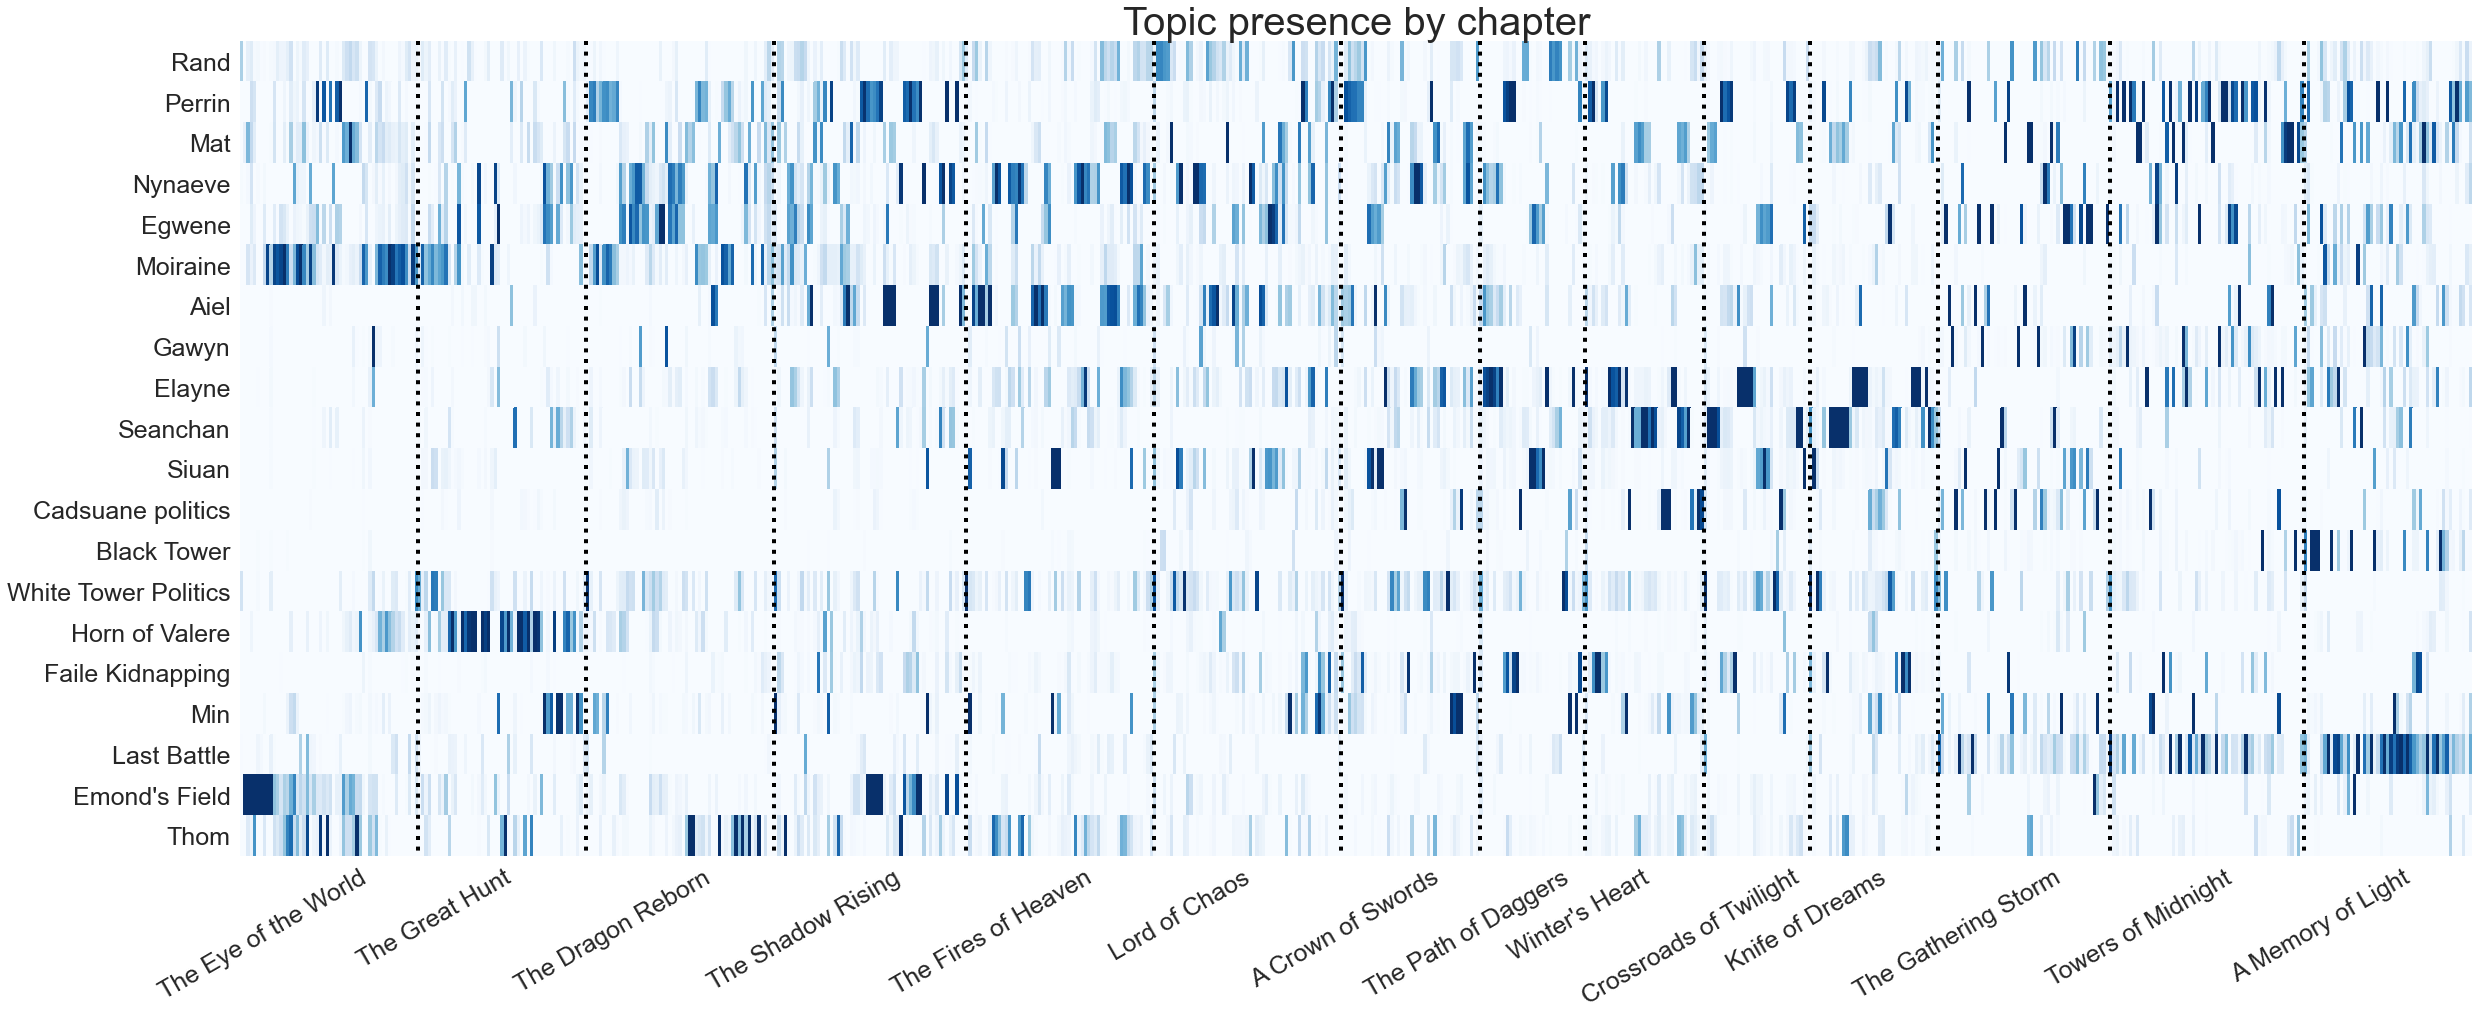

In [45]:
plt.figure(figsize=(40,15))
sns.heatmap(data = topics_by_chapter[topics].T, cmap='Blues', cbar=False, robust=True)
plt.yticks(fontsize=25)
plt.xticks(ticks = tick_locations-20, labels = titles, fontsize = 25, rotation = 30 )
plt.vlines(last_chaps, 0 ,25, color = 'black', linestyles='dotted', linewidths=4)
plt.title('Topic presence by chapter', fontsize = 40)
plt.show()

In [97]:
def plot_chapter_topics(topics_by_chapter, book_num):
    i=book_num-1
    title = titles[i]
    start = starts[i]
    end = ends[i]
    book_df = topics_by_chapter.iloc[start:end]
    chapters = list(book_df['chapter_title'])
    
    plt.figure(figsize=(15,10))
    sns.heatmap(data = book_df[topics].T, cmap='Blues', cbar=False, robust=True, xticklabels=chapters)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize = 15, rotation = 90 )
    plt.title(title + ' topics by chapter', fontsize =24)
    plt.show()

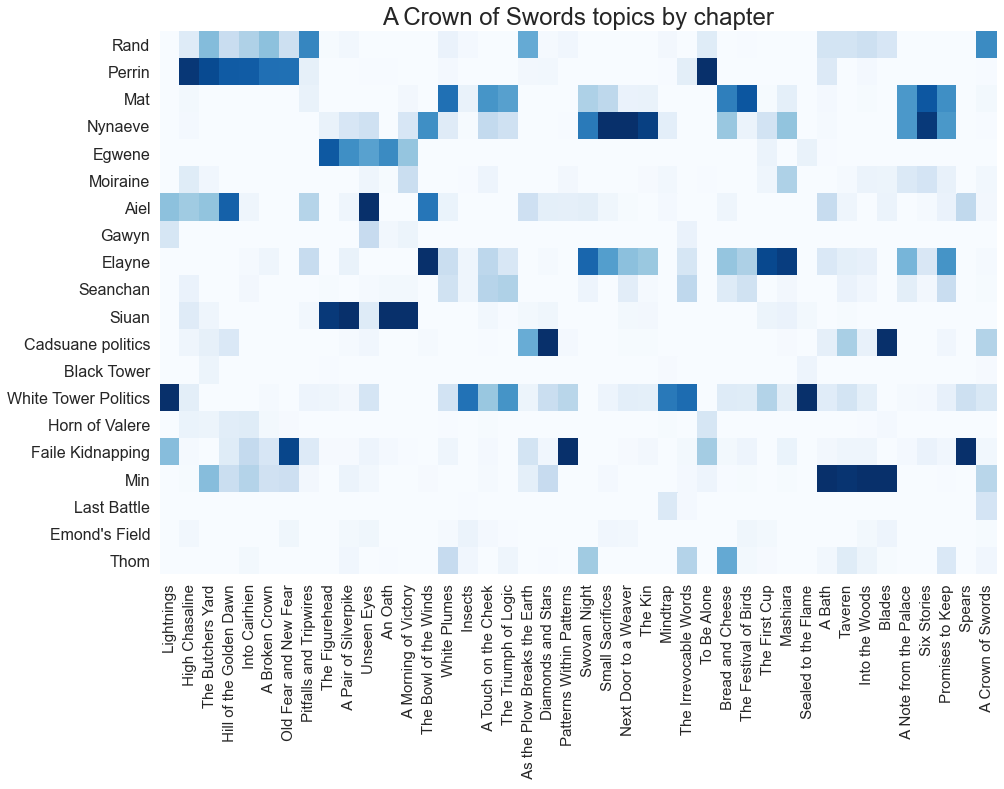

In [102]:
plot_chapter_topics(topics_by_chapter, 7)

## Correlation between topics and ratings

In [59]:
ratings = [4.17, 4.22, 4.25, 4.23,4.15,4.13, 4.03, 3.91, 3.94, 3.81, 4.14, 4.36, 4.41, 4.49]

book_titles = topics_by_chapter['book_title'].unique()

rating_dict = {}
for book,rating in zip(book_titles,ratings):
    rating_dict[book] = rating

topics_by_chapter['book_rating'] = topics_by_chapter['book_title'].map(rating_dict)

In [73]:
rating_correlations = topics_by_chapter[topics+['book_rating']].corr()[['book_rating']]

rating_correlations=rating_correlations.reset_index()\
                                .rename(columns={'index':'Topic', 'book_rating': 'Correlation'})\
                                .sort_values(by='Correlation', ascending=False).iloc[1:]

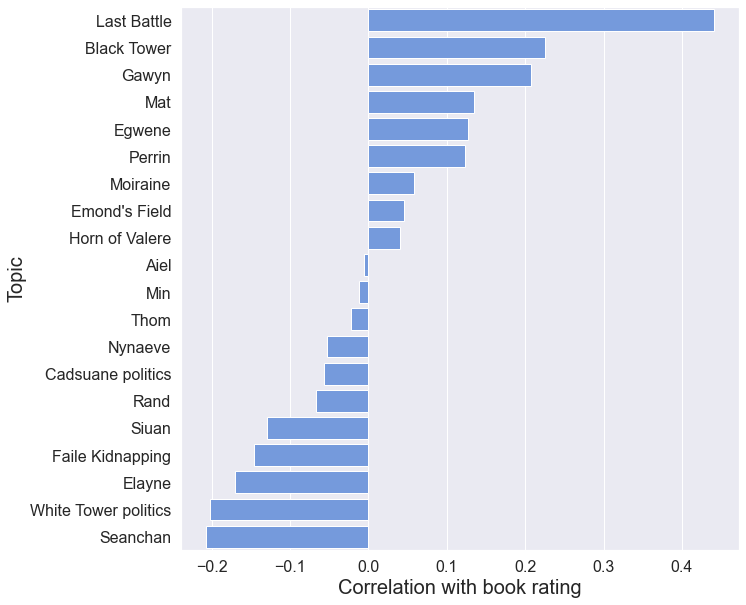

In [79]:
plt.figure(figsize=(10,10))
sns.barplot(data=rating_correlations, y='Topic', x='Correlation', color='cornflowerblue', dodge=False)
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
plt.ylabel('Topic', fontsize = 20)
plt.xlabel('Correlation with book rating', fontsize = 20)
plt.show()